In [ ]:

import numpy as np 
import os
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2

In [ ]:
#mouting google drive with colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.7 MB 7.5 MB/s 
     |████████████████████████████████| 144 kB 52.1 MB/s 
     |████████████████████████████████| 181 kB 56.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=84b0444bbe49d75ac6f4f6dba956d12893b6a02477f3e3f7f9bd1a074da06408
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
#Setting up sweep configuration
sweep_config = {"name": "my-sweep"}
sweep_config['method'] = 'random'
metric = {
    'name': 'accuracy',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric
param_dict= {
      
          "numOfFilters": {
              "values": [64,32]
          },
          "filterMultiplier": {
              "values": [1,0.5,2]
          },
          "augment_data": {
              "values": [True, False]
          },
          "dropout": {
              "values": [0.2,0.3,0.4,0.5]
          },
          "batchNorm": {
              "values": [True, False]
          },        
          "denseSize": {
              "values": [64,128,256,512,1024]
          },
          "epochs": {
              "values": [5,10]
          },
          "lr": {
              "values": [0.01, 0.001, 0.0001, 0.000005, 0.000007]
          }
      }

sweep_config["parameters"] = param_dict
sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment2")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: uh1h94hx
Sweep URL: https://wandb.ai/cs21m073/CS6910_Assignment2/sweeps/uh1h94hx


In [ ]:
##Creating the dataset from google drive
Path = '/content/drive/MyDrive/inaturalist_12K'

trainPath = os.path.join(Path, "train") #training data path
valPath = os.path.join(Path, "val") #validation data path

def createDataset(augmentData=False):
  if augmentData == True:
    train_ = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, rotation_range=90, horizontal_flip=True, validation_split=0.1)
  else:
    train_ = ImageDataGenerator(rescale=1./255, validation_split=0.1)
  
  val_ = ImageDataGenerator(rescale=1./255)

  trainData = train_.flow_from_directory(trainPath, target_size=(227, 227), batch_size=32, subset="training", shuffle =True, seed = 777)
  testData = train_.flow_from_directory(trainPath, target_size=(227, 227), batch_size=32, subset="validation", shuffle = True, seed = 777)
  valData = val_.flow_from_directory(valPath, target_size=(227, 227), batch_size=32)

  return trainData, testData, valData

  


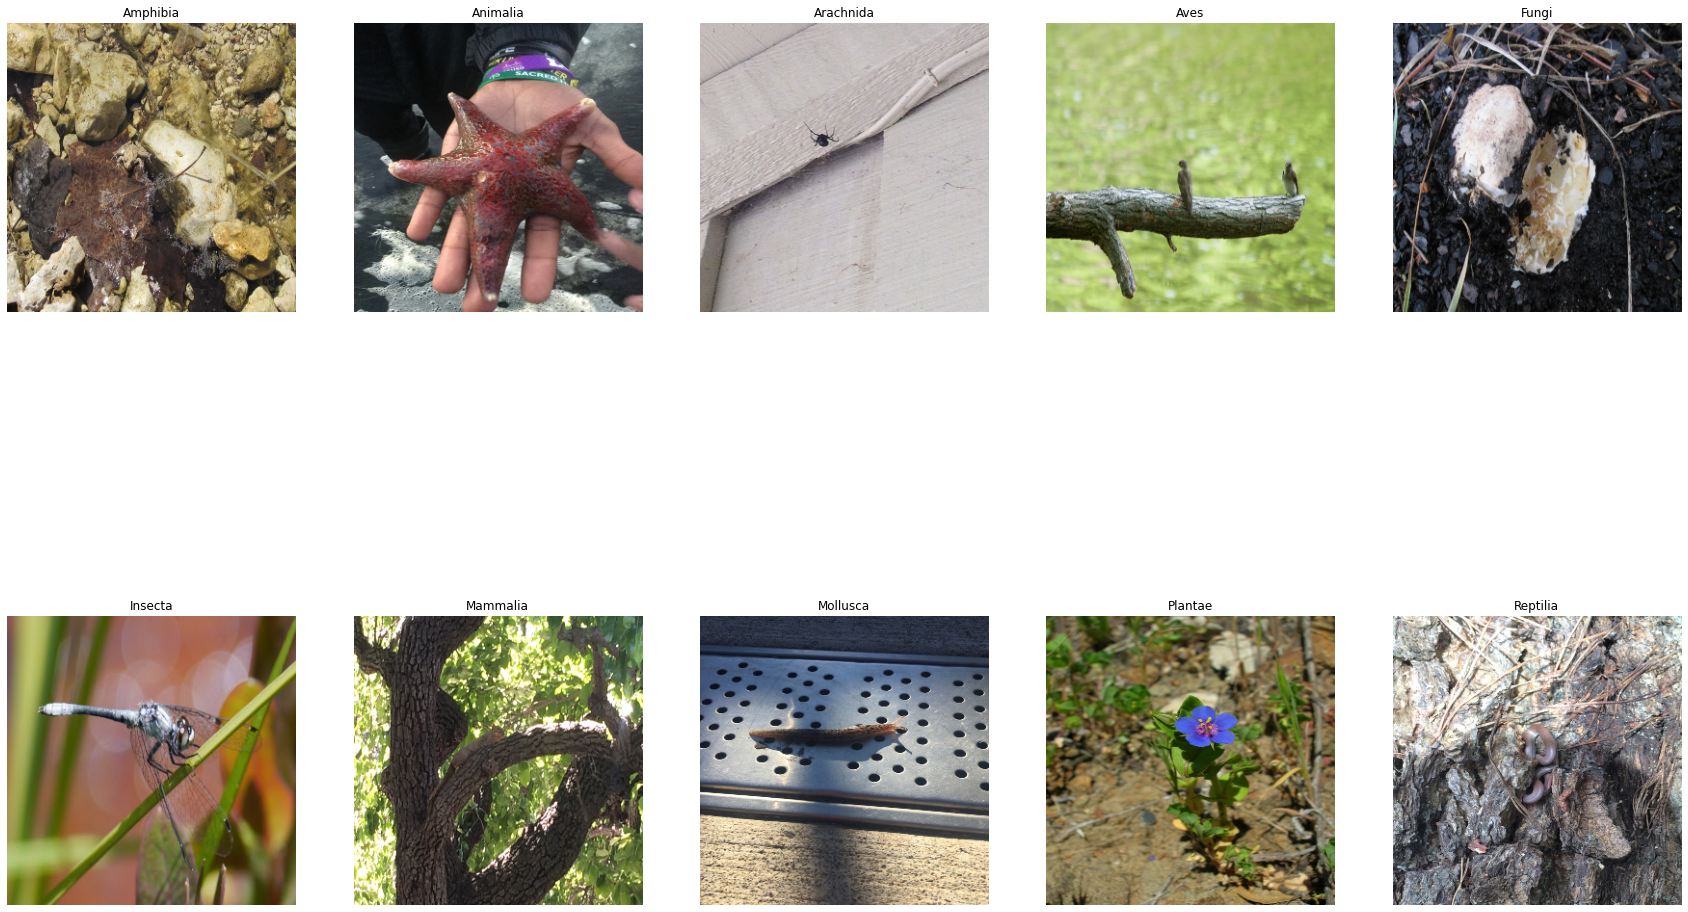

In [ ]:
#Lets see some images
CATEGORIES=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
fig = plt.figure(figsize=(30,20))
rows,columns=2,5
i=1
for category in CATEGORIES:
  DIR = os.path.join(trainPath,category)
  for img in os.listdir(DIR):
    imgPath=os.path.join(DIR,img)
    img=mpimg.imread(imgPath)
    newImg=cv2.resize(img,(300,300))
    fig.add_subplot(rows,columns,i)
    plt.imshow(newImg)
    plt.axis('off')
    plt.title(category)
    i+=1   
    break
plt.savefig('SampleImage.png')

In [ ]:
class ConvolutionClasss:
  def __init__(self):
    pass

  def CNNModel(self, numOfFilters=32, filterMultiplier=1, denseSize=64, imageSize=200, dropout=0.2, batchNorm=False, numClasses=10):
    model = Sequential()
    filterDim1 = 11
    for i in range(5):
        filterDim = filterDim1 - 2*i
        filterSize = (filterDim, filterDim)
        if i==0:
            model.add(Conv2D(numOfFilters, filterSize, input_shape=(imageSize, imageSize, 3), data_format="channels_last"))
        else:
            model.add(Conv2D(numOfFilters, filterSize))
        if batchNorm:
            model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        numOfFilters = int(numOfFilters * filterMultiplier)
    
    model.add(Flatten())
    model.add(Dense(denseSize))
    model.add(Dropout(dropout))
    model.add(Activation("relu"))
    model.add(Dense(numClasses))
    model.add(Activation("softmax"))
    return model


    #Training the model
  def trainModel(self):
        
        config_defaults = {
            "numOfFilters": 32,
            "filterMultiplier": 2,
            "augment_data": False,
            "dropout": 0.3,
            "batchNorm": False,
            "epochs": 10,
            "denseSize": 64,
            "lr": 0.001
        }

        wandb.init(config=config_defaults, magic=True)
        config = wandb.config
        wandb.run.name = "e_{}_filMul_{}_augDat_{}_dropout_{}_bacthNorm_{}_denseSize_{}_lr_{}".format(config.epochs, config.filterMultiplier, config.augment_data, config.dropout, config.batchNorm, config.denseSize, config.lr)
        trainData, testData, valData = createDataset(config.augment_data)

        #structure of CNN(numOfFilters=32, filterMultiplier=1, denseSize=64, imageSize=200, dropout=0.2, batchNorm=False, numClasses=10)
        model = self.CNNModel(config.numOfFilters, config.filterMultiplier, config.denseSize, 227, config.dropout, config.batchNorm)

        model.compile(optimizer=keras.optimizers.Adam(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
        model.fit(trainData, epochs=config.epochs, validation_data=testData, callbacks=[WandbCallback()])
        #model.save("/content/drive/MyDrive/inaturalist_12K/model.h5")




In [ ]:
obj = ConvolutionClasss()

In [ ]:

wandb.agent(sweep_id, function=obj.trainModel)

wandb: Agent Starting Run: qdnv0pv7 with config:
wandb: 	augment_data: True
wandb: 	batchNorm: True
wandb: 	denseSize: 1024
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	filterMultiplier: 2
wandb: 	lr: 7e-06
wandb: 	numOfFilters: 32


Found 9003 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 287s 984ms/step - loss: 2.6540 - categorical_accuracy: 0.1545 - val_loss: 2.3930 - val_categorical_accuracy: 0.1181 - _timestamp: 1648837092.0000 - _runtime: 299.0000
Epoch 2/10
282/282 [==============================] - 280s 992ms/step - loss: 2.3092 - categorical_accuracy: 0.2052 - val_loss: 2.1403 - val_categorical_accuracy: 0.2142 - _timestamp: 1648837372.0000 - _runtime: 579.0000
Epoch 3/10
282/282 [==============================] - 273s 968ms/step - loss: 2.1763 - categorical_accuracy: 0.2365 - val_loss: 2.0703 - val_categorical_accuracy: 0.2613 - _timestamp: 1648837645.0000 - _runtime: 852.0000
Epoch 4/10
282/282 [==============================] - 270s 956ms/step - loss: 2.1122 - categorical_accuracy: 0.2456 - val_loss: 2.0505 - val_categorical_accuracy: 0.2663 - _timestamp: 1648837964.0000 - _runtim

wandb: Agent Starting Run: uo23nsik with config:
wandb: 	augment_data: True
wandb: 	batchNorm: True
wandb: 	denseSize: 1024
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	filterMultiplier: 2
wandb: 	lr: 7e-06
wandb: 	numOfFilters: 64


Found 9003 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 309s 1s/step - loss: 2.4860 - categorical_accuracy: 0.1920 - val_loss: 2.4931 - val_categorical_accuracy: 0.1041 - _timestamp: 1648839954.0000 - _runtime: 314.0000
Epoch 2/10
282/282 [==============================] - 303s 1s/step - loss: 2.1484 - categorical_accuracy: 0.2576 - val_loss: 2.0942 - val_categorical_accuracy: 0.2462 - _timestamp: 1648840258.0000 - _runtime: 618.0000
Epoch 3/10
282/282 [==============================] - 296s 1s/step - loss: 2.0655 - categorical_accuracy: 0.2690 - val_loss: 2.0245 - val_categorical_accuracy: 0.2883 - _timestamp: 1648840554.0000 - _runtime: 914.0000
Epoch 4/10
282/282 [==============================] - 299s 1s/step - loss: 2.0189 - categorical_accuracy: 0.2822 - val_loss: 2.0009 - val_categorical_accuracy: 0.3003 - _timestamp: 1648840852.0000 - _runtime: 1212.0000

wandb: Agent Starting Run: 3a6w4j1j with config:
wandb: 	augment_data: True
wandb: 	batchNorm: True
wandb: 	denseSize: 1024
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	filterMultiplier: 2
wandb: 	lr: 5e-06
wandb: 	numOfFilters: 64


Found 9003 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 300s 1s/step - loss: 2.6033 - categorical_accuracy: 0.1799 - val_loss: 2.4709 - val_categorical_accuracy: 0.1031 - _timestamp: 1648842984.0000 - _runtime: 307.0000
Epoch 2/10
282/282 [==============================] - 293s 1s/step - loss: 2.2086 - categorical_accuracy: 0.2416 - val_loss: 2.1214 - val_categorical_accuracy: 0.2452 - _timestamp: 1648843277.0000 - _runtime: 600.0000
Epoch 3/10
282/282 [==============================] - 293s 1s/step - loss: 2.0998 - categorical_accuracy: 0.2619 - val_loss: 2.0287 - val_categorical_accuracy: 0.2803 - _timestamp: 1648843570.0000 - _runtime: 893.0000
Epoch 4/10
282/282 [==============================] - 291s 1s/step - loss: 2.0463 - categorical_accuracy: 0.2781 - val_loss: 2.0172 - val_categorical_accuracy: 0.3013 - _timestamp: 1648843861.0000 - _runtime: 1184.0000

wandb: Agent Starting Run: p82220hr with config:
wandb: 	augment_data: True
wandb: 	batchNorm: True
wandb: 	denseSize: 1024
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	filterMultiplier: 2
wandb: 	lr: 5e-06
wandb: 	numOfFilters: 64


Found 9003 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 315s 1s/step - loss: 2.5479 - categorical_accuracy: 0.1768 - val_loss: 2.4278 - val_categorical_accuracy: 0.1011 - _timestamp: 1648845984.0000 - _runtime: 322.0000
Epoch 2/10
282/282 [==============================] - 300s 1s/step - loss: 2.2073 - categorical_accuracy: 0.2355 - val_loss: 2.1170 - val_categorical_accuracy: 0.2402 - _timestamp: 1648846284.0000 - _runtime: 622.0000
Epoch 3/10
282/282 [==============================] - 299s 1s/step - loss: 2.0964 - categorical_accuracy: 0.2565 - val_loss: 2.0311 - val_categorical_accuracy: 0.2743 - _timestamp: 1648846584.0000 - _runtime: 922.0000
Epoch 4/10
282/282 [==============================] - 302s 1s/step - loss: 2.0540 - categorical_accuracy: 0.2709 - val_loss: 2.0177 - val_categorical_accuracy: 0.2913 - _timestamp: 1648846885.0000 - _runtime: 1223.0000

In [ ]:

#training the model with this config
'''
model = Sequential()
numOfFilters=64
filterMultiplier = 2
denseSize = 512
dropout = 0.4
batchNorm = True
filterDim1 = 11
numClasses = 10
imageSize = 227
'''
model = obj.CNNModel(numOfFilters=64, filterMultiplier=2, denseSize=1024, imageSize=227, dropout=0.4, batchNorm=True, numClasses=10)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 217, 217, 64)      23296     
                                                                 
 batch_normalization (BatchN  (None, 217, 217, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 217, 217, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     663680    
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 128)    5

In [ ]:

#storing the best model
trainData, testData, valData = createDataset(True)
model.compile(optimizer=keras.optimizers.Adam(0.000007), loss="categorical_crossentropy", metrics="categorical_accuracy")
model.fit(trainData, epochs=15, validation_data=testData)
model.save("/content/drive/MyDrive/inaturalist_12K/model.h5")


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/15
282/282 [==============================] - 6137s 22s/step - loss: 2.4849 - categorical_accuracy: 0.1981 - val_loss: 2.5068 - val_categorical_accuracy: 0.1191
Epoch 2/15
282/282 [==============================] - 244s 866ms/step - loss: 2.1552 - categorical_accuracy: 0.2460 - val_loss: 2.0791 - val_categorical_accuracy: 0.2553
Epoch 3/15
282/282 [==============================] - 238s 843ms/step - loss: 2.0597 - categorical_accuracy: 0.2686 - val_loss: 2.0118 - val_categorical_accuracy: 0.2933
Epoch 4/15
282/282 [==============================] - 241s 855ms/step - loss: 2.0161 - categorical_accuracy: 0.2860 - val_loss: 1.9882 - val_categorical_accuracy: 0.3003
Epoch 5/15
282/282 [==============================] - 239s 848ms/step - loss: 1.9925 - categorical_accuracy: 0.2916 - val_loss: 1.9631 - val_categorical_accuracy: 0.3043
Epoch 6/15
282/282 [===

In [ ]:
#Evaluating the unseen data or validation data
trainData, testData, valData = createDataset(True)
model = keras.models.load_model('/content/drive/MyDrive/inaturalist_12K/model.h5')
model.evaluate(valData)

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
63/63 [==============================] - 847s 13s/step - loss: 1.8681 - categorical_accuracy: 0.3525


[1.868129849433899, 0.35249999165534973]

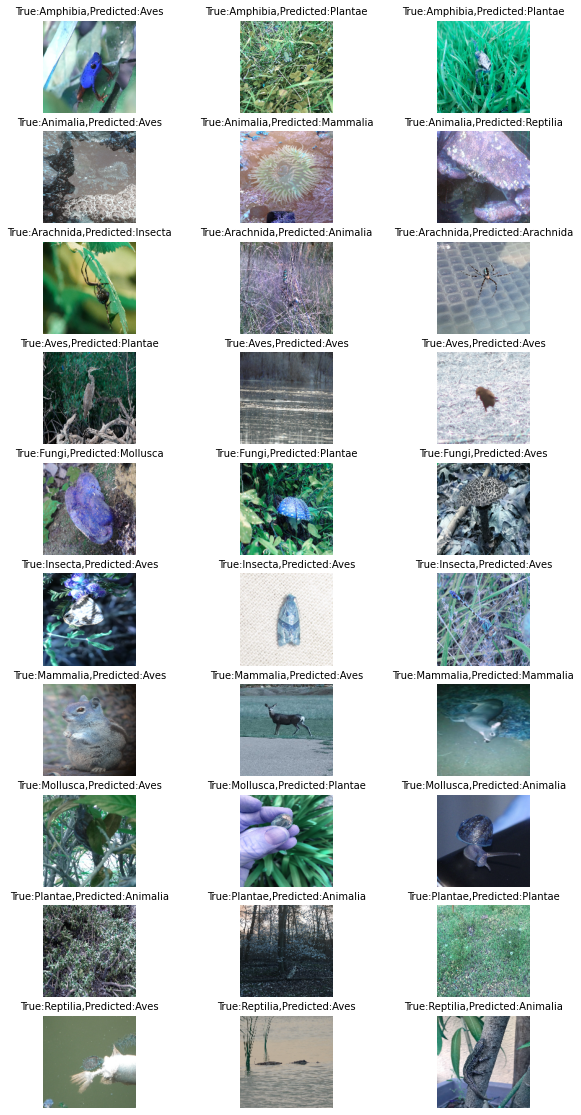

In [ ]:


images = []
trueLabels = []
pred = []

#storing 3 images from each category in images[] and their corresponding true label in trueLabels[] and prediction in pred[]
for catg in CATEGORIES:
  i=0
  PATH = os.path.join('/content/drive/MyDrive/inaturalist_12K/val', catg)
  for img in os.listdir(PATH):
    if i==3:
      break
    else:
      img = cv2.imread(os.path.join(PATH, img))
      images.append(img)
      trueLabels.append(catg)
      pic = cv2.resize(img, (227,227)) / 255.0
      prediction = model.predict(pic.reshape(1,227, 227,3))
      c = prediction.argmax()
      pred.append(CATEGORIES[c])
      i +=1


#plotting all 30 images (three from 10 category each)along with their true label and predicted label
fig = plt.figure(figsize=(10,20))
rows,columns=10,3
i=1
for k in range(30):

  img=cv2.resize(images[k],(150,150))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('True:'+trueLabels[k]+',Predicted:'+pred[k],fontdict={'fontsize':10})
  i+=1   
plt.savefig('prediction.png')

In [ ]:
#model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


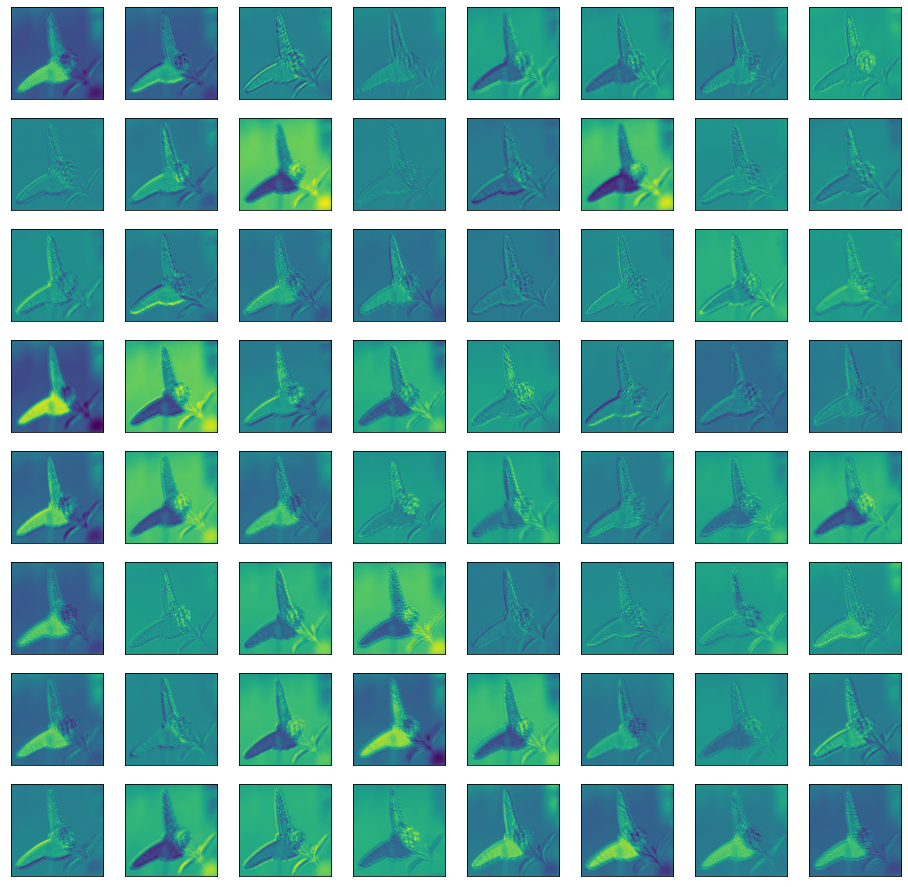

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/inaturalist_12K/model.h5')
layerOutputs = [layer.output for layer in model.layers]
activationModel = tf.keras.models.Model(inputs = model.input, outputs = layerOutputs)

def filterVisualization():
  img_path=('/content/drive/MyDrive/inaturalist_12K/val/Insecta/0ab4b6a3cefc1343da25ecb8a31a9e63.jpg')
  imgs=cv2.imread(img_path)
  new_img=cv2.resize(imgs,(227,227))
  new_img=new_img.reshape(-1, 227, 227, 3)
  activations = activationModel.predict(new_img)

  # Getting Activations of first layer
  firstLayerActivation = activations[0]
  filter = 64
  plt.figure(figsize=(16,16))
  i = 1

  #showing filter visualization
  for idx in range(filter):
    for j in range(3):
        ax = plt.subplot(8, 8, i)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(firstLayerActivation[0, :, :, idx])
    i = i+1
  plt.savefig('filterVisualization.png')
  plt.show()


filterVisualization()

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

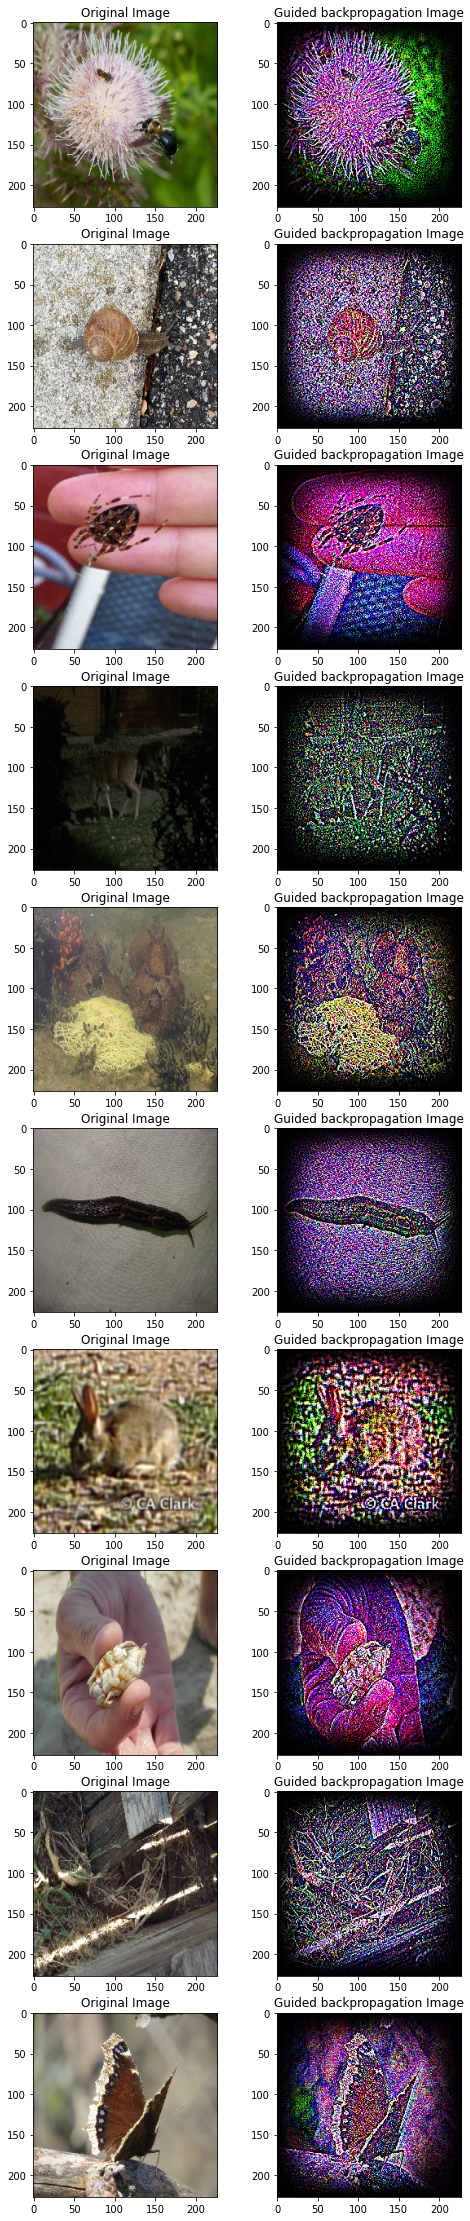

In [ ]:

#guided back propogation
def gbp():

    # loading the data 
    trainData, testData, valData = createDataset(True)

    #loading model having best configuration
    model = tf.keras.models.load_model('/content/drive/MyDrive/inaturalist_12K/model.h5')

    # take upto 5th convolutional layer
    modelTillconv_5 = tf.keras.models.Model(inputs = [model.inputs],outputs = [model.get_layer("conv2d_4").output])

   
    @tf.custom_gradient
    def guidedRelU(x):
        def grad(dy):
            return tf.cast(dy>0, tf.float32) * tf.cast(x>0, tf.float32) * dy
        return tf.nn.relu(x), grad

    layerDictionary = [layer for layer in model.layers[1:] if hasattr(layer,'activation')]
    
    #applying guided relu to all relu activation
    for layer in layerDictionary:
        if layer.activation==tf.keras.activations.relu:
            layer.activation = guidedRelU

    # plotting the images
    fig, ax = plt.subplots(10, 2, figsize=(8, 40))
    images = tf.convert_to_tensor(valData[0][0][:10], dtype=tf.float32)

    for i in range(10):

        with tf.GradientTape() as tape:
            input = tf.expand_dims(images[i], 0)
            tape.watch(input)
            output = modelTillconv_5(input)[0]
        
        gradientImage = tape.gradient(output,input)[0]

        ax[i][0].set_title("Original Image")
        ax[i][0].imshow(images[i])
        ax[i][1].set_title("Guided backpropagation Image")
        ax[i][1].imshow(gradientImage)

    plt.savefig('gbp.jpg')
    plt.show()



gbp()


In [ ]:
_,_,v = createDataset(True)

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [ ]:
v[0][0][:10]

array([[[[0.4431373 , 0.50980395, 0.5372549 ],
         [0.40784317, 0.47450984, 0.5019608 ],
         [0.4156863 , 0.47058827, 0.5058824 ],
         ...,
         [0.40784317, 0.48627454, 0.4784314 ],
         [0.40784317, 0.48627454, 0.4784314 ],
         [0.42352945, 0.49803925, 0.4901961 ]],

        [[0.4156863 , 0.48235297, 0.50980395],
         [0.42352945, 0.4901961 , 0.5176471 ],
         [0.43529415, 0.4901961 , 0.5254902 ],
         ...,
         [0.4039216 , 0.48627454, 0.4666667 ],
         [0.43137258, 0.5137255 , 0.49411768],
         [0.41176474, 0.5019608 , 0.4784314 ]],

        [[0.41960788, 0.48627454, 0.5176471 ],
         [0.42352945, 0.4901961 , 0.5176471 ],
         [0.4431373 , 0.5019608 , 0.5294118 ],
         ...,
         [0.43137258, 0.5019608 , 0.5019608 ],
         [0.43137258, 0.5058824 , 0.49803925],
         [0.4039216 , 0.49411768, 0.47058827]],

        ...,

        [[0.69411767, 0.7019608 , 0.7490196 ],
         [0.6666667 , 0.6745098 , 0.72156864]